### Group ID: 44

### Group Members Name with Student ID:

1. BEDANTA BIKASH DUTTA (2024AA05186)
2. LELLA NIKHILESWAR (2024AA05976)
3. NIRMAL J (2024AA05189)
4. PRANAV DUBEY (2024AA05660)


# Scenario

A pharmaceutical company is conducting clinical trials to evaluate the effectiveness of three antiretroviral drug combinations for treating HIV-positive patients. Due to the ethical and cost constraints of clinical trials, it is critical to identify the most effective treatment regimen using the least number of patients. Each treatment (or “arm”) can lead to different outcomes depending on patient responses. The effectiveness of each treatment is evaluated using a reward function derived from the improvement in patients’ immune system markers and survival status.


# Problem Definition

You are provided with a clinical dataset where each record corresponds to a patient, including the treatment they received and the resulting health outcomes. Your task is to simulate a clinical trial environment using various MAB strategies to sequentially recommend treatments and observe outcomes. The objective is to maximize the overall success rate across trials by identifying and favouring the most effective treatment.


# Dataset

You will be provided a dataset containing the following fields:

- **_Age (age)_**: Patient's age in years at baseline.
- **_Weight (wtkg)_**: Continuous feature representing weight in kilograms at baseline.
- **_Gender (gender)_**: Binary indicator of gender (0 = Female, 1 = Male).
- **_CD4 Counts (cd40, cd420)_**: Integer values representing CD4 counts at baseline and 20+/-5 weeks.
- **_Treatment Indicator (trt)_**: Categorical feature indicating the type of treatment received (0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only).
- **_Censoring Indicator (label)_**: Binary indicator (1 = failure, 0 = censoring) denoting patient status.

**_Link for accessing dataset:_**
https://drive.google.com/file/d/1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-/view?usp=sharing


# Environment Setup

**_Arms (Actions):_** The treatment types (trt)

- Arm 0: ZDV only
- Arm 1: ZDV + ddI
- Arm 2: ZDV + Zal
- Arm 3: ddI only

**Reward Function:**

Reward `r` is defined as:

`r = 1, if (label == 0) and (cd420 > cd40)`

`r = 0, otherwise`

This reward represents a successful treatment outcome as an increase in CD4 count and survival.

**Assumptions:**

_Number of Iterations:_ Run the simulation for at least 3000 trials (iterations), with the option to extend the number of trials depending on the convergence behavior or observed reward trends. In each iteration, simulate one patient trial using one of the bandit policies.


# Requirements and Deliverables:

Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.


# Import Libraries


In [26]:
from __future__ import annotations

import logging
import random
import sys
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
logger = logging.getLogger("DRL")
logger.propagate = False

for handler in logger.handlers:
    logger.removeHandler(handler)

logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter("%(levelname)s | %(message)s")
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


# Load Dataset (0.5M)


In [28]:
# Code for Dataset loading and print dataset statistics
# -----write your code below this line---------

# Using the download link from Google Drive as the data is shared with us that way and the link is publicly accessible
clinical_trials = pd.read_csv(
    "https://drive.usercontent.google.com/u/0/uc?id=1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-&export=download",
)

In [29]:
clinical_trials.head()

,age,wtkg,gender,cd40,cd420,trt,label
0,48,89.8128,0,422,477,2,0
1,61,49.4424,0,162,218,3,1
2,45,88.4520,1,326,274,3,0
3,47,85.2768,1,287,394,3,0
4,43,66.6792,1,504,353,0,0


In [30]:
clinical_trials.describe()

,age,wtkg,gender,cd40,cd420,trt,label
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,35.248247,75.125311,0.827957,350.501169,371.307153,1.520804,0.243572
std,8.709026,13.263164,0.377506,118.573863,144.634909,1.127890,0.429338
min,12.000000,31.000000,0.000000,0.000000,49.000000,0.000000,0.000000
25%,29.000000,66.679200,1.000000,263.500000,269.000000,1.000000,0.000000
50%,34.000000,74.390400,1.000000,340.000000,353.000000,2.000000,0.000000
75%,40.000000,82.555200,1.000000,423.000000,460.000000,3.000000,0.000000
max,70.000000,159.939360,1.000000,1199.000000,1119.000000,3.000000,1.000000


In [31]:
clinical_trials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     2139 non-null   int64  
 1   wtkg    2139 non-null   float64
 2   gender  2139 non-null   int64  
 3   cd40    2139 non-null   int64  
 4   cd420   2139 non-null   int64  
 5   trt     2139 non-null   int64  
 6   label   2139 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 117.1 KB


# Design a Clinical Trial Environment (0.5M)


In [32]:
# Code for environment setup along with reward function
# -----write your code below this line---------


class ClinicalTrialEnvironment:
    """Clinic environment for simulating patient treatments and outcomes."""

    def __init__(self, patient_records: pd.DataFrame) -> None:
        """Initialize the Clinic environment.

        Parameters
        ----------
        patient_records : pd.DataFrame
            DataFrame containing patient records.

        """
        self._patient_records = patient_records

    def treatment_effect(self, patient_record: pd.Series) -> int:
        """Treatment Effect.

        Reward based on the treatment
        If the patient status is censoring (label == 0) and the CD4 count improves (cd420 > cd40),
        the treatment was successful and the reward should be 1 else 0.

        Parameters
        ----------
        patient_record : pd.Series
            Patient details.

        Returns
        -------
        int
            Whether treatment was successful or not.

        """
        if (
            # Patient is censoring
            patient_record["label"] == 0
        ) and (
            # CD4 count is improving
            patient_record["cd420"] > patient_record["cd40"]
        ):
            return 1
        return 0

    def get_patient_record(self, patient_id: int) -> pd.Series:
        """Retrieve a patient record by patient ID.

        Parameters
        ----------
        patient_id : int
            ID of the patient. This is the index of the patient record in DataFrame.

        Returns
        -------
        pd.Series
            The patient record as a pandas Series.

        """
        return self._patient_records[patient_id]

    # Defining treatments as a property to avoid manual override
    @property
    def treatments(self) -> dict[int, str]:
        """Dictionary of available treatments.

        Returns
        -------
        dict[int, str]
            Mapping of treatment codes to treatment names.

        """
        return {0: "ZDV only", 1: "ZDV + ddI", 2: "ZDV + Zal", 3: "ddI only"}

    def treatment(self) -> int:
        """Randomly select a treatment.

        Returns
        -------
        str
            The id of the randomly selected treatment.

        """
        return random.choice([0, 1, 2, 3])  # noqa: S311

    def treatment_name(self, treatment_id: int) -> str:
        """Randomly select a treatment.

        Parameters
        ----------
        treatment_id : int
            The treatment id to filter patient records.

        Returns
        -------
        str
            The id of the randomly selected treatment.

        """
        return self.treatments[treatment_id]

    def sample_patient_with_treatment(self, treatment_id: int) -> pd.Series:
        """Sample a patient record with the specified treatment.

        Parameters
        ----------
        treatment_id : int
            The treatment id to filter patient records.

        Returns
        -------
        pd.Series
            A randomly sampled patient record with the specified treatment.

        """
        return self._patient_records.loc[self._patient_records["trt"] == treatment_id].sample(1).iloc[0]


In [33]:
clinical_trial_environment = ClinicalTrialEnvironment(patient_records=clinical_trials)

# Abstract Class for Policy


In [34]:
class Policy(ABC):
    """Abstract base class for bandit policies."""

    def __init__(self, number_of_arms: int, **kwargs: dict) -> None:  # noqa: D107
        self._number_of_arms = number_of_arms
        self._arm_calls = np.zeros(number_of_arms)
        self._arm_rewards = np.zeros(number_of_arms)
        self._total_calls = 0
        self._kwargs = kwargs

    @abstractmethod
    def select_arm(self) -> int:
        """Select an arm to pull.

        Returns
        -------
        int
            The index of the selected arm.

        """
        ...

    def update_arm_call(self, arm: int, reward: int) -> None:
        """Update the call and reward counts for a given arm.

        Parameters
        ----------
        arm : int
            The index of the arm to update.
        reward : int
            The reward received from pulling the arm.

        """
        self._arm_calls[arm] += 1
        self._arm_rewards[arm] += reward

        self._total_calls += 1

# Function for simulating a policy


In [35]:
def simulate_policy(
    policy: Policy,
    environment: ClinicalTrialEnvironment,
    iterations: int,
    *,
    verbose: bool = False,
) -> tuple[list[str], list[int]]:
    """Simulate a policy interacting with the clinic environment.

    Parameters
    ----------
    policy : Policy
        The bandit policy to use for selecting treatments.
    environment : Clinic
        The clinic environment containing patient records and treatments.
    iterations : int
        Number of iterations to simulate.
    verbose : bool, optional
        If True, logs details of each iteration.

    Returns
    -------
    tuple[list[str], list[int]]
        A tuple containing the list of selected treatment names and their corresponding effects.

    """
    selected_treatments = []
    treatment_effects = []

    for iteration in range(1, iterations + 1):
        # Select a treatment using the policy
        treatment = policy.select_arm()
        # Select a random patient from the environment who has undergone this treatment
        sample_patient = environment.sample_patient_with_treatment(treatment_id=treatment)
        # Calculate the effect of the treatment on the patient
        treatment_effect = environment.treatment_effect(patient_record=sample_patient)

        # Obtain the name of the treatment
        treatment_name = environment.treatment_name(treatment_id=treatment)

        # Update the tracking lists
        selected_treatments.append(treatment_name)
        treatment_effects.append(treatment_effect)

        # Update the policy
        policy.update_arm_call(arm=treatment, reward=treatment_effect)

        if verbose:
            message = f"Iteration: {iteration: 05}, Selected Treatment: {treatment} ({treatment_name.center(9)}), Treatment Effect: {treatment_effect}"  # noqa: E501
            logger.info(message)
    return selected_treatments, treatment_effects

# Using Random Policy (0.5M)

Implement a random policy for treatment selection and print each iteration. (Mandatory)


In [36]:
#  run the environment with an agent that is guided by a random policy
# -----write your code below this line---------


class RandomPolicy(Policy):
    """Policy that selects an arm at random."""

    def select_arm(self) -> int:
        """Select an arm to pull at random.

        Returns
        -------
        int
            The index of the randomly selected arm.

        """
        return np.random.default_rng().integers(0, self._number_of_arms)


random_policy = RandomPolicy(number_of_arms=4)

random_policy_selected_treatments, random_policy_treatment_effects = simulate_policy(
    policy=random_policy,
    environment=clinical_trial_environment,
    iterations=3000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0002, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0004, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0005, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0006, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0007, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0009, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0011, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

# Using Greedy Policy (1M)

Implement the Greedy policy that always selects the treatment with the highest average reward and print each iteration. (Mandatory)


In [37]:
#  run the environment with an agent that is guided by a greedy policy
# -----write your code below this line---------


class GreedyPolicy(Policy):
    """Policy that selects an arm using the greedy strategy."""

    def select_arm(self) -> int:
        """Select an arm to pull using the greedy strategy.

        Returns
        -------
        int
            The index of the selected arm.

        """
        # If this is the first call select an arm at random
        if self._total_calls == 0:
            return np.random.default_rng().integers(0, self._number_of_arms)

        # Calculate mean reward per arm
        mean_rewards = np.divide(self._arm_rewards, self._arm_calls, where=self._arm_calls != 0)

        # Return the index with maximum reward
        return np.argmax(mean_rewards)


greedy_policy = GreedyPolicy(number_of_arms=4)

# Random policy simulation
greedy_policy_selected_treatments, greedy_policy_treatment_effects = simulate_policy(
    policy=greedy_policy,
    environment=clinical_trial_environment,
    iterations=3000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0002, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0005, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0007, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0009, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0010, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0011, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0012, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

# Using Epsilon-Greedy Policy (1.5M)

Implement the ε-Greedy policy with ε = 0.1, 0.2, 0.5. Report iteration-wise selections and rewards. Determine which ε yields the best result. (Mandatory)


In [38]:
#  run the environment with an agent that is guided by a epsilon-greedy policy
# -----write your code below this line---------


class EpsilonGreedyPolicy(Policy):
    """Policy that selects an arm using the epsilon-greedy strategy."""

    def __init__(self, number_of_arms: int, **kwargs: dict) -> None:  # noqa: D107
        super().__init__(number_of_arms, **kwargs)
        if "epsilon" not in kwargs:
            message = "Missing required input parameter `epsilon`"
            raise TypeError(message)
        self._epsilon = kwargs["epsilon"]

    def select_arm(self) -> int:
        """Select an arm to pull using the epsilon strategy.

        Returns
        -------
        int
            The index of the selected arm.

        """
        if (
            # If this is the first call select an arm at random
            self._total_calls == 0
            or
            # Allow random selection occasionally when the random value is less than epsilon
            np.random.default_rng().random() < self._epsilon
        ):
            return np.random.default_rng().integers(0, self._number_of_arms)

        # Calculate mean reward per arm
        mean_rewards = np.divide(self._arm_rewards, self._arm_calls, where=self._arm_calls != 0)

        # Return the index with maximum reward
        return np.argmax(mean_rewards)

## ε-Greedy (ε=0.1)


In [39]:
epsilon_greedy_policy_01 = EpsilonGreedyPolicy(number_of_arms=4, epsilon=0.1)
epsilon_greedy_policy_01_selected_treatments, epsilon_greedy_policy_01_treatment_effects = simulate_policy(
    policy=epsilon_greedy_policy_01,
    environment=clinical_trial_environment,
    iterations=3000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0002, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0003, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0005, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0008, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0009, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0011, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

ε-Greedy (ε=0.2)


In [40]:
epsilon_greedy_policy_02 = EpsilonGreedyPolicy(number_of_arms=4, epsilon=0.2)
epsilon_greedy_policy_02_selected_treatments, epsilon_greedy_policy_02_treatment_effects = simulate_policy(
    policy=epsilon_greedy_policy_02,
    environment=clinical_trial_environment,
    iterations=3000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0002, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0003, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0004, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0005, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0007, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0008, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0009, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0010, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0011, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0012, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

ε-Greedy (ε=0.5)


In [41]:
epsilon_greedy_policy_05 = EpsilonGreedyPolicy(number_of_arms=4, epsilon=0.5)
epsilon_greedy_policy_05_selected_treatments, epsilon_greedy_policy_05_treatment_effects = simulate_policy(
    policy=epsilon_greedy_policy_05,
    environment=clinical_trial_environment,
    iterations=3000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0002, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0003, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0004, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0005, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0008, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0009, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0011, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0012, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

# Using UCB (1M)

Implement the UCB algorithm for treatment selection and print each iteration. (Mandatory)


In [42]:
#  run the environment with an agent that is guided by a UCB
# -----write your code below this line---------


class UCBPolicy(Policy):
    """Policy that selects an arm using the UCB strategy."""

    def select_arm(self) -> int:
        """Select an arm to pull using the Upper Confidence Bound (UCB) strategy.

        Returns
        -------
        int
            The index of the selected arm.

        """
        # Call all arms once before calling the same arm again
        if self._total_calls < self._number_of_arms:
            return self._total_calls

        # Calculate mean reward per arm
        mean_rewards = np.divide(self._arm_rewards, self._arm_calls, where=self._arm_calls != 0)

        # Calculate confidence bounds
        confidence_bounds = np.sqrt(
            2
            * np.log(
                # Total calls + 1 is the current iteration value
                # Total calls is updated after calling the `select_arm` function
                self._total_calls + 1,
            )
            / self._arm_calls,
        )

        # Calculate UCB values
        ucb_values = mean_rewards + confidence_bounds
        return np.argmax(ucb_values)


ucb_policy = UCBPolicy(number_of_arms=4)

ucb_policy_selected_treatments, ucb_policy_treatment_effects = simulate_policy(
    policy=ucb_policy,
    environment=clinical_trial_environment,
    iterations=3000,
    verbose=True,
)

INFO | Iteration:  0001, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0002, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0003, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0004, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0005, Selected Treatment: 0 ( ZDV only), Treatment Effect: 1
INFO | Iteration:  0006, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 1
INFO | Iteration:  0007, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 1
INFO | Iteration:  0008, Selected Treatment: 3 ( ddI only), Treatment Effect: 1
INFO | Iteration:  0009, Selected Treatment: 0 ( ZDV only), Treatment Effect: 0
INFO | Iteration:  0010, Selected Treatment: 1 (ZDV + ddI), Treatment Effect: 0
INFO | Iteration:  0011, Selected Treatment: 2 (ZDV + Zal), Treatment Effect: 0
INFO | Iteration:  0012, Selected Treatment: 3 ( ddI only), Treatment Effect: 0
INFO | Iteration:  0013, Selected Treatm

# Plot the cumulative rewards for all policies on a single graph to compare their performance. (0.5M)


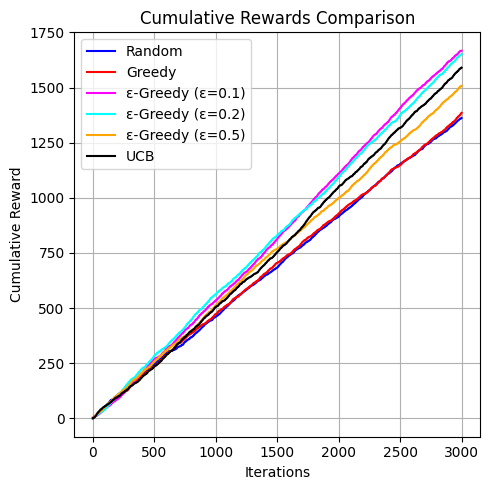

In [43]:
# -----write your code below this line---------

plotting_data = {
    "Random": random_policy_treatment_effects,
    "Greedy": greedy_policy_treatment_effects,
    "ε-Greedy (ε=0.1)": epsilon_greedy_policy_01_treatment_effects,
    "ε-Greedy (ε=0.2)": epsilon_greedy_policy_02_treatment_effects,
    "ε-Greedy (ε=0.5)": epsilon_greedy_policy_05_treatment_effects,
    "UCB": ucb_policy_treatment_effects,
}

colors = ["blue", "red", "magenta", "cyan", "orange", "black"]

plt.figure(figsize=(5, 5), dpi=100)

for i, (name, rewards) in enumerate(plotting_data.items()):
    cumulative_rewards = np.cumsum(rewards)
    plt.plot(cumulative_rewards, label=name, color=colors[i])

plt.xlabel("Iterations")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards Comparison")

plt.legend()
plt.grid(visible=True)

plt.tight_layout()
plt.show()

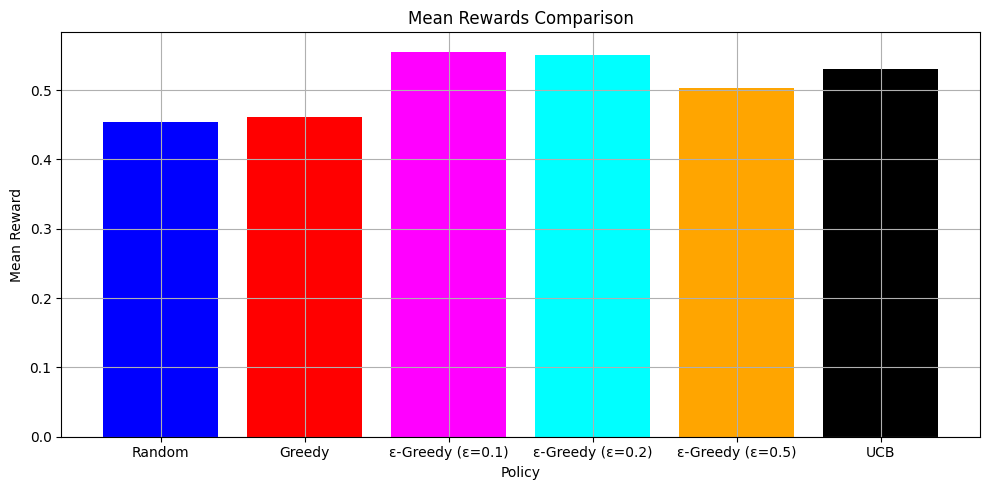

In [44]:
plt.figure(figsize=(10, 5), dpi=100)

mean_rewards_per_policy = {name: np.mean(rewards) for name, rewards in plotting_data.items()}

plt.bar(mean_rewards_per_policy.keys(), mean_rewards_per_policy.values(), color=colors)

plt.xlabel("Policy")
plt.ylabel("Mean Reward")
plt.title("Mean Rewards Comparison")
plt.grid(visible=True)

plt.tight_layout()
plt.show()

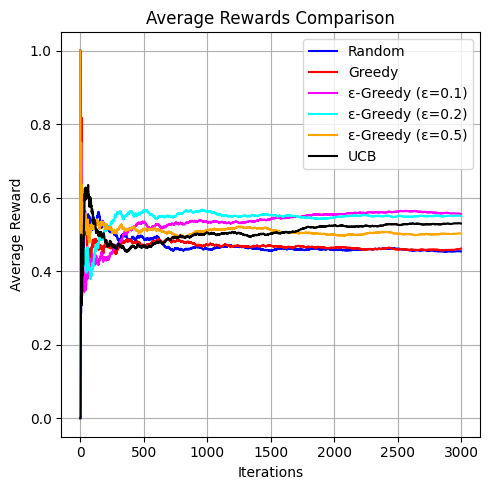

In [45]:
plt.figure(figsize=(5, 5), dpi=100)

for i, (name, rewards) in enumerate(plotting_data.items()):
    cumulative_average_rewards = np.cumsum(rewards) / (
        np.arange(1, len(rewards) + 1)
    )  # Normalize by number of iterations
    plt.plot(cumulative_average_rewards, label=name, color=colors[i])

plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Rewards Comparison")

plt.legend()
plt.grid(visible=True)

plt.tight_layout()
plt.show()

# Conclusion (0.5M)

write a conclusion (approximately 250 words) summarizing which treatment policy was most effective. Discuss the balance between exploration and exploitation in your simulations.

`----write below this line------`

Based on the results we can see that cumulative and average values are high for UCB and
Epsilon greedy algorithms with low epsilon values.

The most effective algorithm was Epsilon greedy with epsilon = 0.1, which achieved the highest cumulative and average reward values.

The random policy explored the most but did not exploit the results. All the learning done will be useless in terms of random policy. But the greedy algorithm fails to understand the effectiveness of other available option. It immediately selects the best working option. There might have been a better option if explored. To find the best option we need the ability to explore and use the best option we need to exploit.
